<h1>Table of Contents<span class="tocSkip"></span></h1>


# Introduction


**What?** Rossmann Store Sales predictions with Prophet and XGBoost



# What is the goal?


- This project is built using the data from Rossmann competition hosted at Kaggle.
- Time Series Analysis & Forecasting

    - Exploratory Data Analysis with Python (ECDF, missing values, Correlation analysis ...)
    - Time Series Analysis per store type (Seasonal decomposition, Autocorrelation)
    - Forecasting with Prophet
    - Predictive modeling with XGboost



# Import modules

In [53]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pandas import datetime
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 35

# Load the dataset

In [2]:
# importing train data to learn
train = pd.read_csv("../DATASETS/Rossmann_Store_Sales/train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')

# additional store data
store = pd.read_csv("../DATASETS/Rossmann_Store_Sales/store.csv", 
                    low_memory = False)

# Exploratory Data Analysis 


- Short description:
    - Sales: the turnover for any given day (target variable).
    - Customers: the number of customers on a given day.
    - Open: an indicator for whether the store was open: 0 = closed, 1 = open.
    - Promo: indicates whether a store is running a promo on that day.
    - StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. 
    - SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools.



In [3]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(5).append(train.tail(5))

In total:  (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1
2013-01-01,1114,2,0,0,0,0,a,1



- We are dealing with time series data so it will probably serve us to extract dates for further analysis. 
- We also have two likely correlated vaiables in the dataset, which can be combined into a new feature



In [4]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64


- ECDF: empirical cumulative distribution function
- To get the first impression about continious variables in the data we can plot ECDF.
- About 20% of data has zero amount of sales/customers that we need to deal with and almost 80% of time daily amount of sales was less than 1000.
- So what about zero sales, is it only due to the fact that the store is closed?



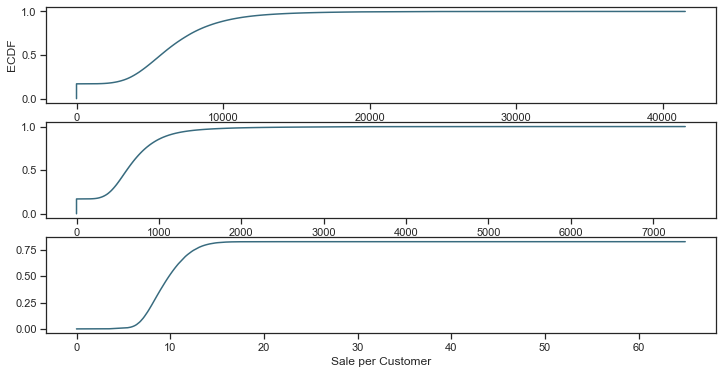

In [5]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))
rcParams['font.size'] = 35

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sale per Customer');

In [6]:
# closed stores and no sales
train[(train.Open == 0) & (train.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN



- There're 172817 closed stores in the data. 
- It is about 10% of the total amount of observations. 
- To avoid any biased forecasts we will drop these values. 
- What about opened stores with zero sales?



In [7]:
# opened stores with zero sales
zero_sales = train[(train.Open != 0) & (train.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)

In total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN



- Interestingly enough, there are opened store with no sales on working days. 
- There're only 54 days in the data, so we can assume that there were external factors involved, for example manifestations.  



In [8]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train["Open"] != 0) & (train['Sales'] != 0)]

print("In total: ", train.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 13)



- **Store info**
    - Store: a unique Id for each store
    - StoreType: differentiates between 4 different store models: a, b, c, d
    - Assortment: describes an assortment level: a = basic, b = extra, c = extended
    - CompetitionDistance: distance in meters to the nearest competitor store
    - CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
    - Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
    - Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
    - PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store



In [9]:
# additional information about the stores
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [10]:
# missing values?
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


-  We have few variables with missing values that we need to deal with. Let's start with the CompetitionDistance.
- Apperently this information is simply missing from the data. No particular pattern observed. 
- In this case, it makes a complete sense to replace NaN with the median values (which is twice less that the average).



In [11]:
# missing values in CompetitionDistance
store[pd.isnull(store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [12]:
# fill NaN with a median value (skewed distribuion)
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)

Continuing further with missing data. What about `Promo2SinceWeek`? May it be that we observe unsusual data points?

In [13]:
# no promo = no information about the promo?
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

No, if there's no `Promo2` then there's no information about it. We can replace these values by zeros. The same goes for tha variables deducted from the competition, `CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear`.

In [14]:
# replace NA's by 0
store.fillna(0, inplace = True)

In [15]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train, store, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


In this section we will closely look at different levels of `StoreType` and how the main metric `Sales` is distributed among them.  

In [16]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


`StoreType` B has the highest average of Sales among all others, however we have much less data for it. So let's print an overall sum of `Sales` and `Customers` to see which `StoreType` is the most selling and crowded one:

In [17]:
train_store.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


Clearly stores of type A. `StoreType` D goes on the second place in both `Sales` and `Customers`.
What about date periods? Seaborn's facet grid is the best tool for this task:

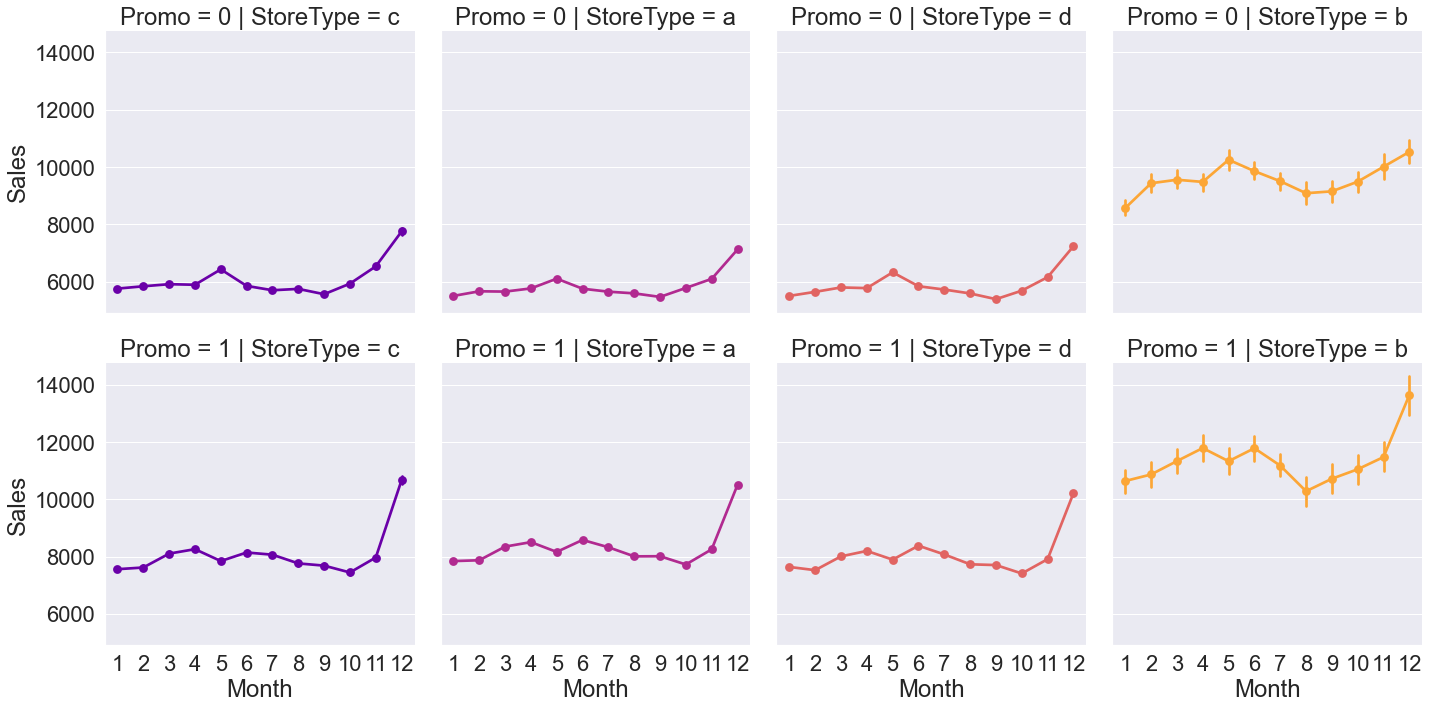

In [18]:
# sales trends
sns.set(font_scale = 2) 
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

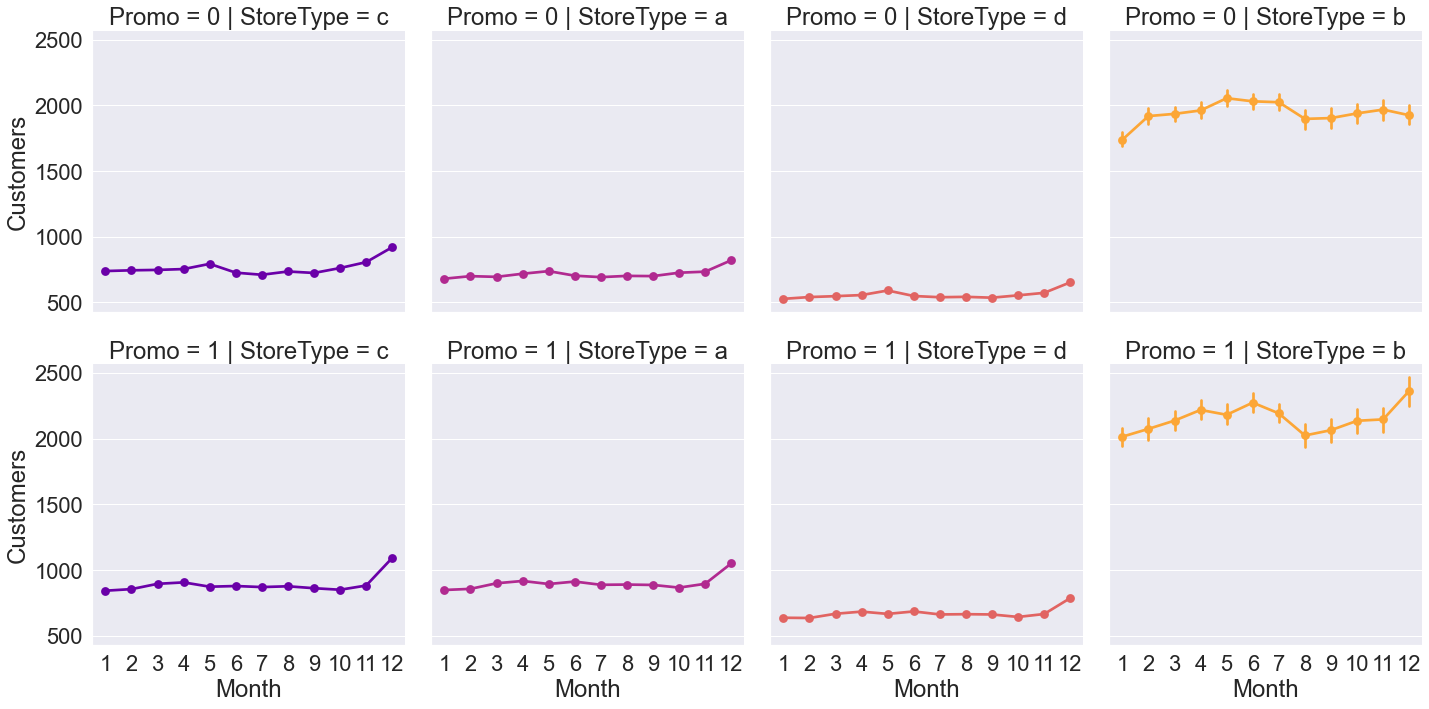

In [19]:
# sales trends
sns.factorplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 


- All store types follow the same trend but at different scales depending on the presence of the (first) promotion Promo and StoreType itself (case for B).
- Already at this point, we can see that Sales escalate towards Christmas holidays. 



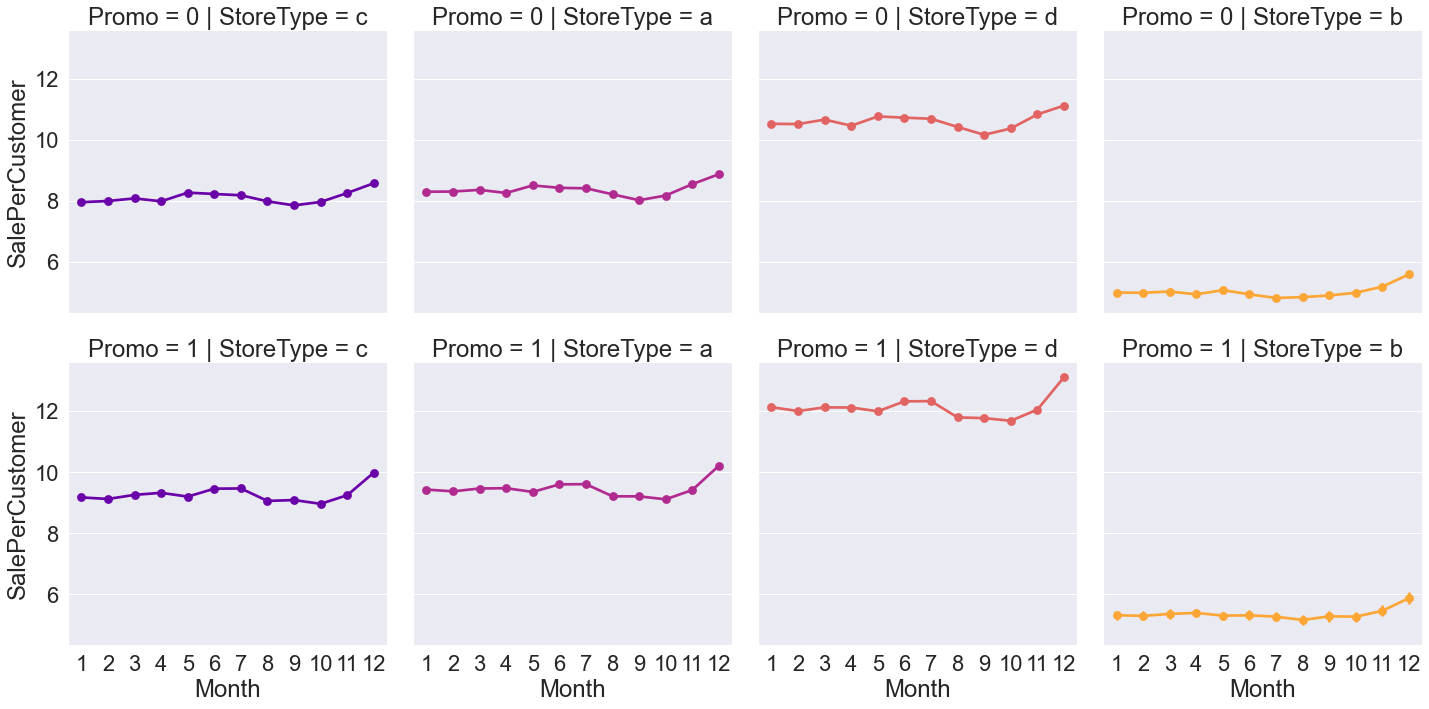

In [20]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 


- Eventhough the plots above showed `StoreType` B as the most selling and performant one, in reality it is not true. The highest `SalePerCustomer` amount is observed at the `StoreType` D, about 12€ with `Promo` and 10€ without. As for `StoreType` A and C it is about 9€. 
- Low `SalePerCustomer` amount for `StoreType` B describes its Buyer Cart: there are a lot of people who shop essentially for "small" things (or in a little quantity). Plus we saw that overall this `StoreType` generated the least amount of sales and customers over the period.
    


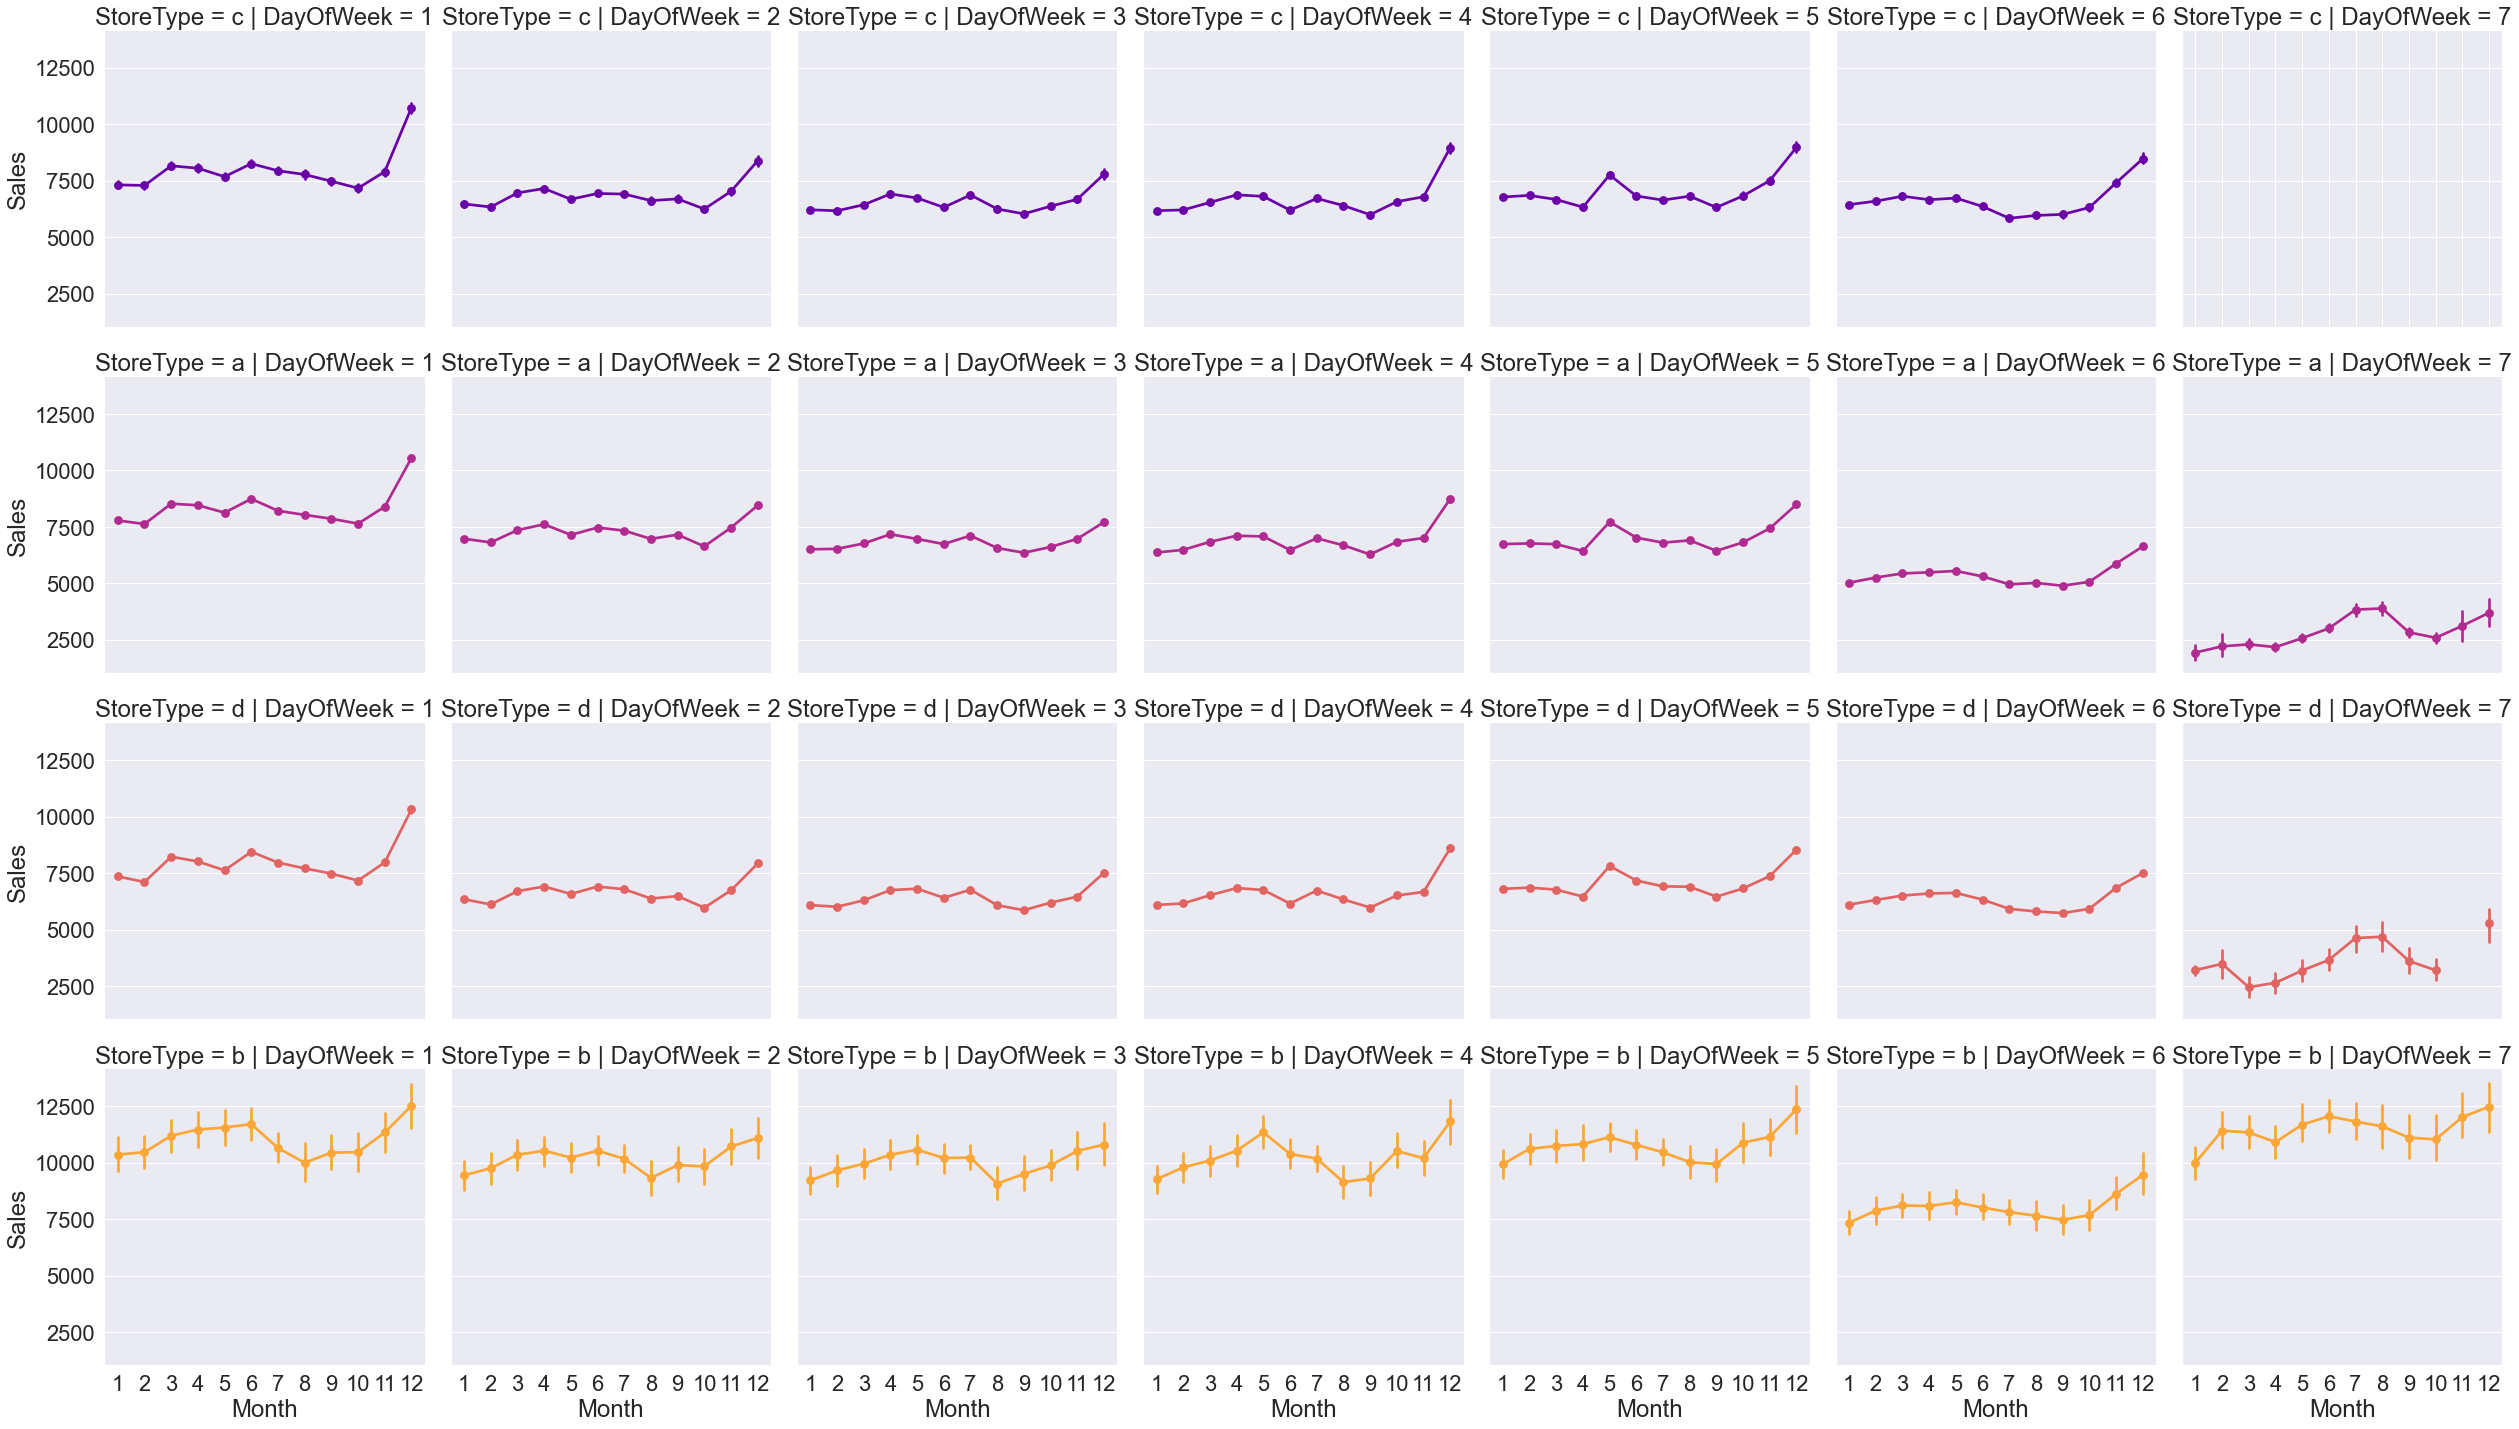

In [21]:
# customers
sns.set(font_scale = 2) 
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c) 


- We see that stores of `StoreType` C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of `StoreType` D are closed on Sundays only from October to December.
- Bt the way what are the stores which are opened on Sundays?



In [22]:
# stores which are opened on Sundays
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])


- To complete our preliminary data analysis, we can add variables describing the period of time during which competition and promotion were opened:



In [23]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekOfYear - train_store.Promo2SinceWeek) / 4.0

# replace NA's by 0
train_store.fillna(0, inplace = True)

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526



- The most selling and crowded `StoreType` A doesn't appear to be the one the most exposed to competitors. 
- Instead it's a `StoreType` B, which also has the longest running period of promotion.



**Correlational Analysis**

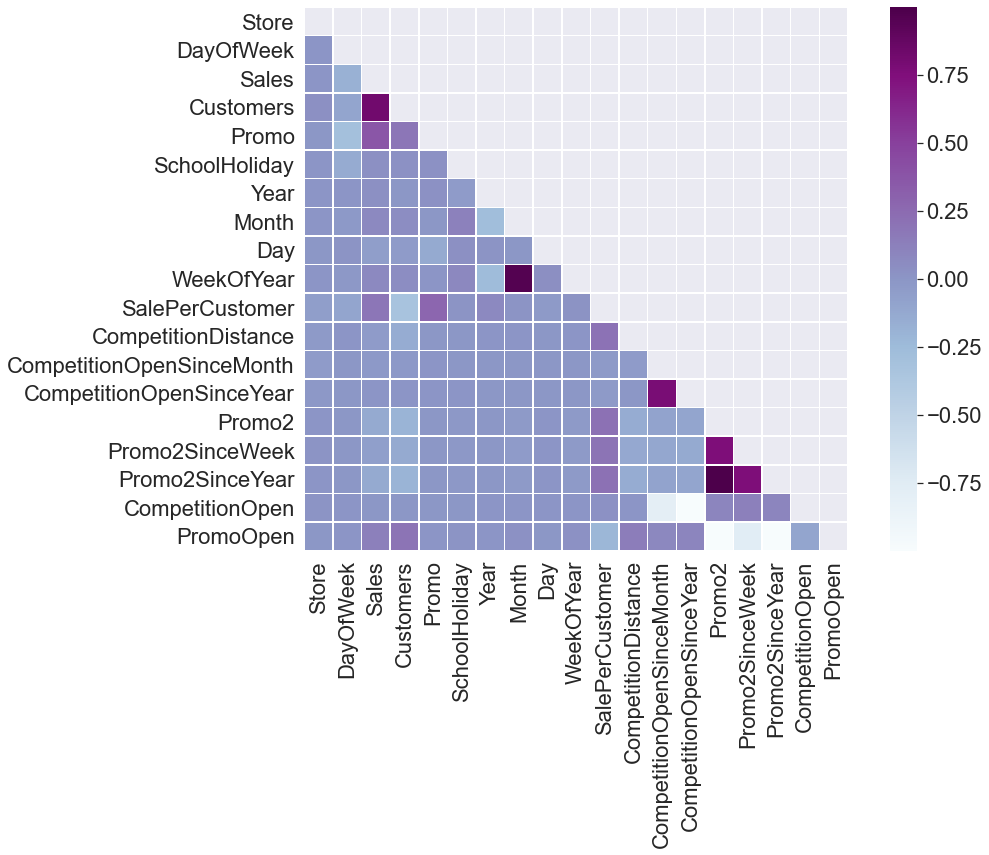

In [24]:
# Compute the correlation matrix but exclude 'Open' variable
corr_all = train_store.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (15, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()


- As mentioned before, we have a strong positive correlation between the amount of Sales and Customers of a store. We can also observe a positive correlation between the fact that the store had a running promotion (`Promo` equal to 1) and amount of `Customers`. 

- However, as soon as the store continues a consecutive promotion (`Promo2` equal to 1) the number of `Customers` and `Sales` seems to stay the same or even decrease, which is described by the pale negative correlation on the heatmap. The same negative correlation is observed between the presence of the promotion in the store and the day of a week.



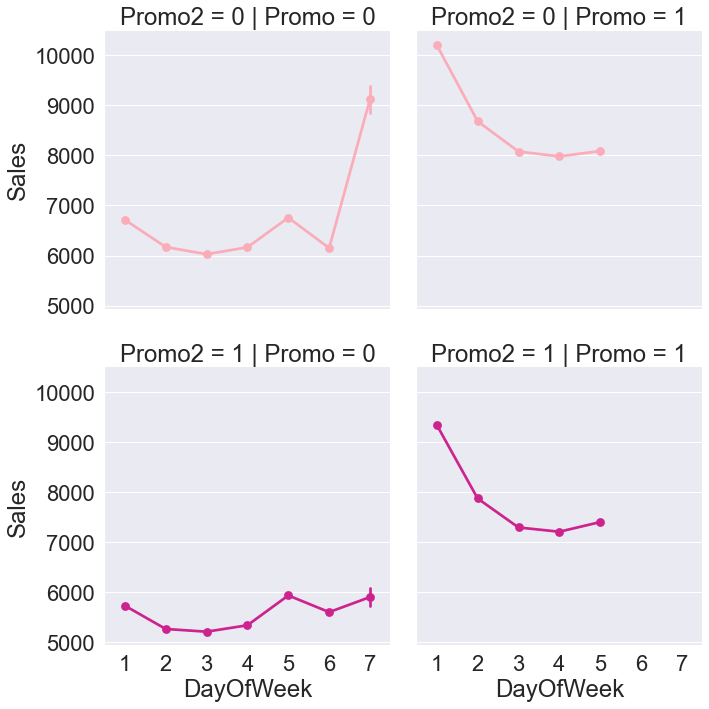

In [25]:
# sale per customer trends
sns.factorplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu') 


- In case of no promotion, both `Promo` and `Promo2` are equal to 0, `Sales` tend to peak on Sunday (!). Though we should note that `StoreType` C doesn't work on Sundays. So it is mainly data from `StoreType` A, B and D.
- On the contrary, stores that run the promotion tend to make most of the `Sales` on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (`Promo` and `Promo2` are equal to 1).
- `Promo2` alone doesn't seem to be correlated to any significant change in the `Sales` amount. This can be also prooved by the blue pale area on the heatmap above.



---

**Conclusion of EDA**


- The most selling and crowded `StoreType` is A.

- The best "Sale per Customer" `StoreType` D indicates to the higher Buyer Cart. We could also assume that the stores of this types are situated in the rural areas, so that customers prefer buying more but less often.

- Low `SalePerCustomer` amount for `StoreType` B indicates to the possible fact that people shop there essentially for small things. Which can also indicate to the label of this store type - "urban" - as it's more accessible for public, and customers don't mind shopping there from time to time during a week.

- Customers tends to buy more on Mondays when there's one promotion running (`Promo`) and on Sundays when there is no promotion at all (both `Promo` and `Promo1` are equal to 0).

- Promo2 alone doesn't seem to be correlated to any significant change in the `Sales` amount.



# Time-Series Analysis per Store Type


- We build a time series analysis on store types instead of individual stores. The main advantage of this approach is its simplicity of presentation and overall account for different trends and seasonaltities in the dataset. 
- In this section, we will analyse time series data: its trends, sesonalities and autocorrelation. 
- Usually at the end of the analysis, we are able to develop a seasonal ARIMA (Autoregression Integrated Moving Average) model but it won't be our main focus today. 
- Instead, we try to understand the data, and only later come up with the forecasts using Prophet methodology.



**Seasonality**


We take four stores from store types to represent their group:
- Store number 2 for `StoreType` A
- Store number 85 for `StoreType` B, 
- Store number 1 for `StoreType` C 
- Store number 13 for `StoreType` D. 

It also makes sense to downsample the data from days to weeks using the `resample` method to see the present trends more clearly.



<AxesSubplot:xlabel='Date'>

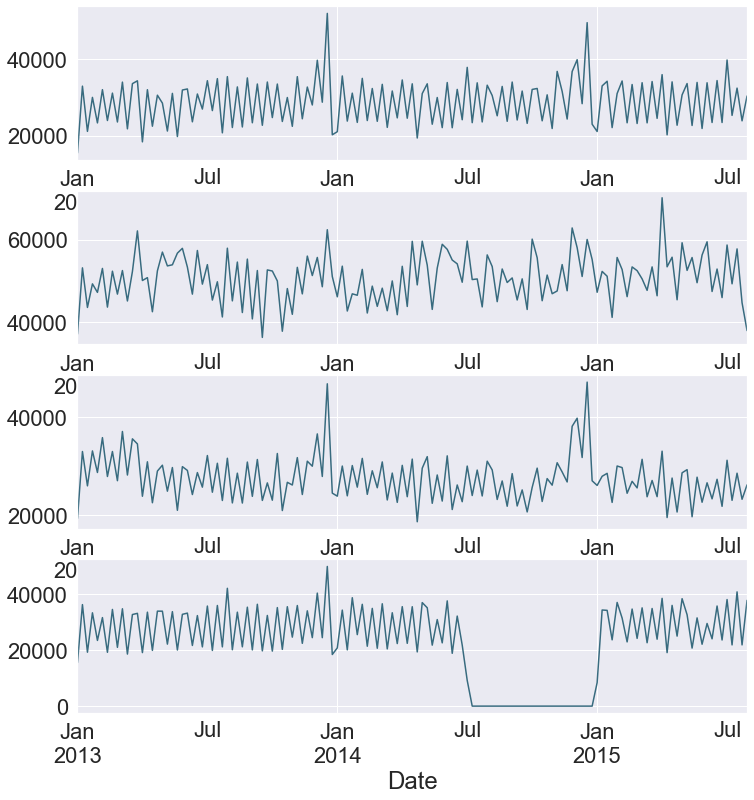

In [26]:
# preparation: input should be float type
train['Sales'] = train['Sales'] * 1.0

# store types
sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)


- Retail sales for `StoreType` A and C tend to peak for the Christmas season and then decline after the holidays. 
- We might have seen the same trend for `StoreType` D (at the bottom) but there is no information from July 2014 to January 2015 about these stores as they were closed.



**Yearly trend**


- The next thing to check the presence of a trend in series.
- Overall sales seems to increase, however not for the `StoreType` C (a third from the top). 
- Eventhough the `StoreType` A is the most selling store type in the dataset, it seems that it cab follow the same decresing trajectory as `StoreType` C did.



<AxesSubplot:xlabel='Date'>

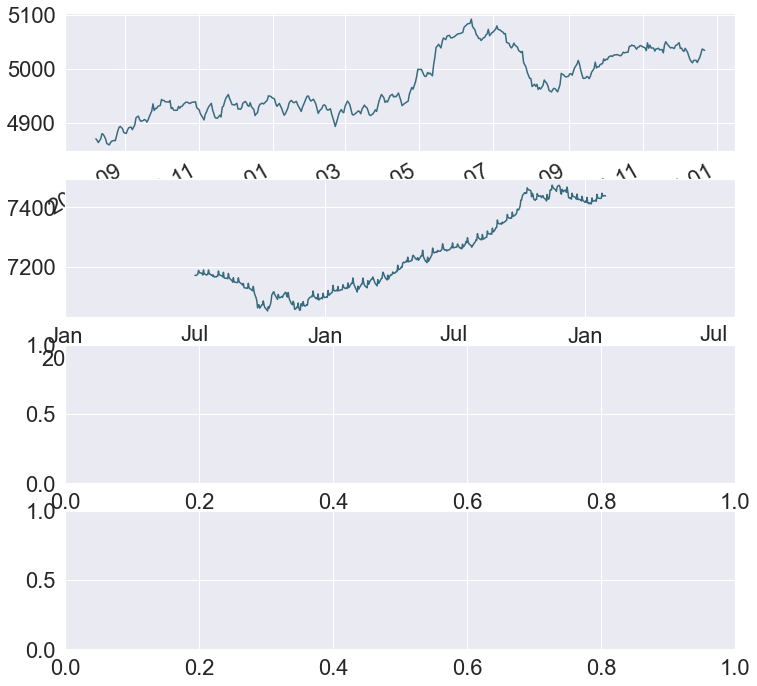

In [29]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', freq = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', freq = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

#decomposition_c = seasonal_decompose(sales_c, model = 'additive', freq = 365)
#decomposition_c.trend.plot(color = c, ax = ax3)

#decomposition_d = seasonal_decompose(sales_d, model = 'additive', freq = 365)
#decomposition_d.trend.plot(color = c, ax = ax4)

**Autocorrelaion**


- The next step in ourtime series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. 

- ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

- PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4. 



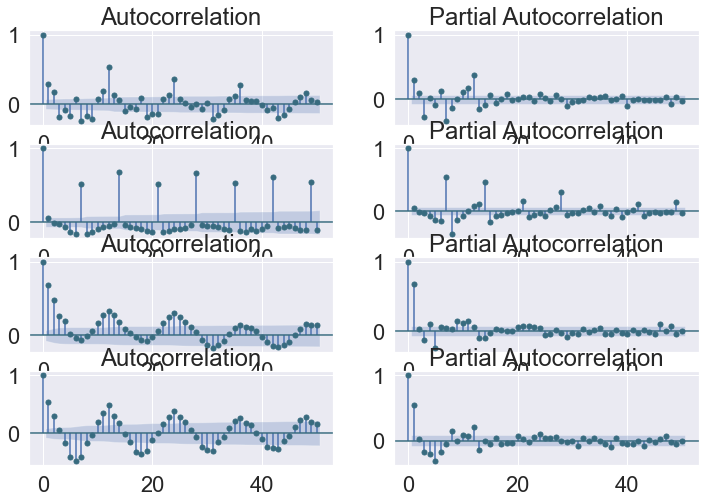

In [30]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()


- Type A and type B: Both types show seasonalities at certain lags. For type A, it is each 12th observation with positives spikes at the 12 (s) and 24(2s) lags and so on. For type B it's a weekly trend with positives spikes at the 7(s), 14(2s), 21(3s) and 28(4s) lags. 

- Type C and type D: Plots of these two types are more complex. It seems like each observation is coorrelated to its adjacent observations. 



# Time Series Analysis and Forecasting with Prophet


- Forecasting for the next 6 weeks for the first store
- It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. 
- It enables performing automated forecasting .



In [31]:
# importing data
df = pd.read_csv("../DATASETS/Rossmann_Store_Sales/train.csv",  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [32]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


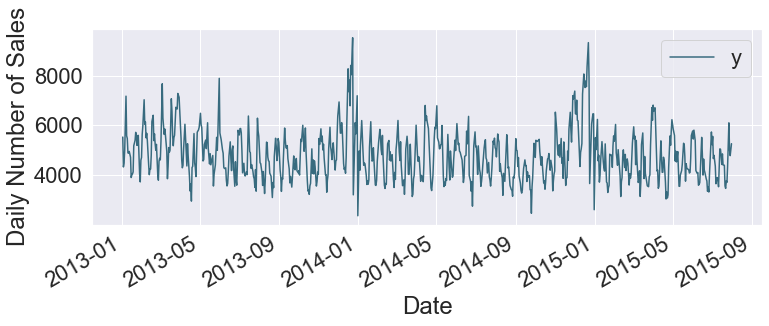

In [33]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()


- Prophet also allows to [model for holidays](https://facebookincubator.github.io/prophet/docs/holiday_effects.html), and that's what we do here.
- The StateHoliday variable in the dataset indicates a state holiday, at which all stores are normally closed. There are also school holidays in the dataset at which ceratin stores are also closing their doors.



In [34]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-06-04
1,state_holiday,2015-06-04
2,state_holiday,2015-06-04
3,state_holiday,2015-06-04
4,state_holiday,2015-06-04


In [35]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


First week to forecast.


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [36]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4092.034043,2544.969086,5706.631779
817,2015-09-06,4086.988821,2438.928278,5690.961896
818,2015-09-07,4161.793901,2553.983248,5822.588632
819,2015-09-08,3664.076887,2133.757750,5268.578694
820,2015-09-09,3550.829069,1956.989903,5204.791485
821,2015-09-10,3462.363550,1963.695124,5113.972795
822,2015-09-11,3717.063878,1978.535685,5270.531371


In [37]:
# The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})


- Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).
- As we see Prophet catches the trends and most of the time gets future values right.
- One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series plus manyally included holidayes contribute to the overall forecasted values:




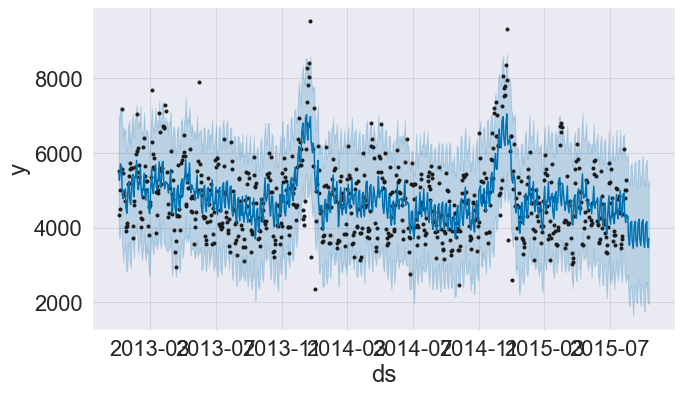

In [38]:
# visualizing predicions
my_model.plot(forecast);

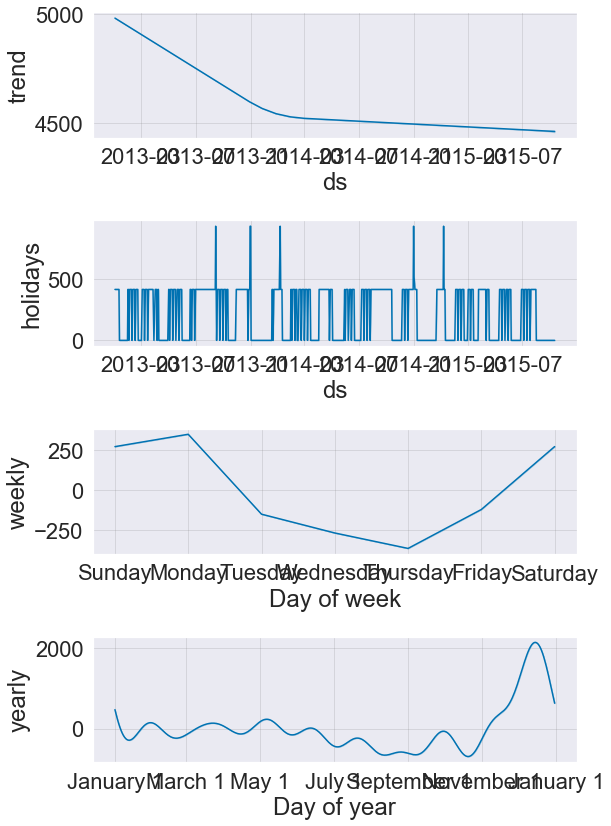

In [40]:
my_model.plot_components(forecast);


- The first plot shows that the monthly sales of store number 1 has been linearly decreasing  over time and the second shows the holiays gaps included in the model. 
- The third plot highlights the fact that the weekly volume of last week sales peaks towards the Monday of the next week, while the forth plot shows that the most buzy season occurs during the Christmas holidays.



**Conclusion of Time Series forecasting**


During this part we discussed time series analysis with `.seasonal_decompose()`, `ACF` and `PCF` plots and fited forecasting model using a new procedure by Facebook `Prophet`.

We can now present main advantages and drawbacks of time series forecasting:

__Advantages__
- Powerfull tool for the time series forecasting as it accounts for time dependencies, seasonalities and holidays (Prophet: manualy).
- Easily implemented with R `auto.arima()` from `forecast` package, which runs a complex grid search and sophisticated algorythm behind the scene.

__Drawbacks__
- Doesn't catch interactions between external features, which could improve the forecasting power of a model. In our case, these variables are `Promo` and `CompetitionOpen`. 
- Eventhough Prophet offers an automated solution for ARIMA, this methodology is under development and not completely stable.
- Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the the biggest drawback for new companies.
- Seasonal ARIMA in Python has 7 hyperparameters which can be tuned only manually affecting significantly the speed of the forecasting process.



# Alternative Approach: Regression XGBoost


- As we already saw in the previos section our data is higly seasonal and not random (dependent). 
- Therefore, before fitting any models we need to "smooth" (make it more stationary???) target variable Sales. 
- The typical preprocessing step is to log transform the data in question. 
- Once we perform the forecasting we will unwind log transformations in reverse order.



In [41]:
# to predict to
test = pd.read_csv("../DATASETS/Rossmann_Store_Sales/test.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')
test.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0
2015-09-17,4,8,4,1.0,1,0,0
2015-09-17,5,9,4,1.0,1,0,0


In [42]:
# test: missing values?
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [43]:
test[pd.isnull(test.Open)]

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,480,622,4,NaN,1,0,0
2015-09-16,1336,622,3,NaN,1,0,0
2015-09-15,2192,622,2,NaN,1,0,0
2015-09-14,3048,622,1,NaN,1,0,0
2015-09-12,4760,622,6,NaN,0,0,0
2015-09-11,5616,622,5,NaN,0,0,0
2015-09-10,6472,622,4,NaN,0,0,0
2015-09-09,7328,622,3,NaN,0,0,0
2015-09-08,8184,622,2,NaN,0,0,0


In [44]:
# We see that these stores should be normally opened. Let's assume that they are then.
# replace NA's in Open variable by 1 
test.fillna(1, inplace = True)

In [45]:
# data extraction
test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear

# encoding to numerical
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
test.StateHoliday.replace(mappings, inplace = True)

train_store.Assortment.replace(mappings, inplace = True)
train_store.StoreType.replace(mappings, inplace = True)
train_store.StateHoliday.replace(mappings, inplace = True)
train_store.drop('PromoInterval', axis = 1, inplace = True)

store.StoreType.replace(mappings, inplace = True)
store.Assortment.replace(mappings, inplace = True)
store.drop('PromoInterval', axis = 1, inplace = True)

In [46]:
# take a look on the train and store again
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
0,1,5,5263,555,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
1,1,4,5020,546,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
2,1,3,4782,523,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
3,1,2,5011,560,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75
4,1,1,6102,612,1,1,0,1,2015,7,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,82.0,24187.75


In [47]:
print("Joining test set with an additional store information.")
test_store = pd.merge(test, store, how = 'inner', on = 'Store')

test_store['CompetitionOpen'] = 12 * (test_store.Year - test_store.CompetitionOpenSinceYear) + (test_store.Month - test_store.CompetitionOpenSinceMonth)
test_store['PromoOpen'] = 12 * (test_store.Year - test_store.Promo2SinceYear) + (test_store.WeekOfYear - test_store.Promo2SinceWeek) / 4.0

print("In total: ", test_store.shape)
test_store.head()

Joining test set with an additional store information.
In total:  (41088, 21)


,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,CompetitionOpen,PromoOpen
0,1,1,4,1.0,1,0,0,2015,9,17,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
1,857,1,3,1.0,1,0,0,2015,9,16,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
2,1713,1,2,1.0,1,0,0,2015,9,15,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
3,2569,1,1,1.0,1,0,0,2015,9,14,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.50
4,3425,1,7,0.0,0,0,0,2015,9,13,...,3,1,1270.0,9.0,2008.0,0,0.0,0.0,84.0,24189.25


**Model Training**

In [48]:
# split into training and evaluation sets
# excluding Sales and Id columns
predictors = [x for x in train_store.columns if x not in ['Customers', 'Sales', 'SalePerCustomer']]
y = np.log(train_store.Sales) # log transformation of Sales
X = train_store

# split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 42)

In [49]:
# predictors
X.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'SalePerCustomer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionOpen', 'PromoOpen'],
      dtype='object')

In [50]:
# evaluation metric: rmspe
# Root Mean Square Percentage Error
# code chunk shared at Kaggle

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

**Tuning Parameters**

-  `eta`: Step size used in updating weights. Lower value means slower training but better convergence. 
- `num_round`: Total number of iterations.
- `subsample`: The ratio of training data used in each iteration; combat overfitting. Should be configured in the range of 30% to 80% of the training dataset, and compared to a value of 100% for no sampling.
- `colsample_bytree`: The ratio of features used in each iteration, default 1.
- `max_depth`: The maximum depth of each tree. If we do not limit max depth, gradient boosting would eventually overfit.
- `early_stopping_rounds`: If there's no increase in validation score for a given number of iterations, the algorithm will stop early, also combats overfitting.

In [51]:
# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [52]:
# XGB with xgboost library
dtrain = xgb.DMatrix(X_train[predictors], y_train)
dtest = xgb.DMatrix(X_test[predictors], y_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]

xgb_model = xgb.train(params, dtrain, 300, evals = watchlist,
                      early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

[14:12:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:7.4434	test-rmse:7.44306	train-rmspe:0.999527	test-rmspe:0.999528
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:6.70076	test-rmse:6.70044	train-rmspe:0.998823	test-rmspe:0.998824
[2]	train-rmse:6.03251	test-rmse:6.03223	train-rmspe:0.997553	test-rmspe:0.997554
[3]	train-rmse:5.43135	test-rmse:5.43103	train-rmspe:0.99541	test-rmspe:0.995412
[4]	train-rmse:4.89032	test-rmse:4.89002	train-rmspe:0.992016	test-rmspe:0.992019
[5]	train-rmse:4.40368	test-rmse:4.40341	train-rmspe:0.986938	test-rmspe:0.986942
[6]	train-rmse:3.96569	test-rmse:3.96535	train-rmspe:0.979732	test-rmspe:0.979737
[7]	train-rmse:3.57178	test-rmse:3.57142	train-rmspe:0.969935	test-rmspe:0.969935
[8]	train-rmse:3.21748	test-rmse:3.21711	train-rmspe:0.957159	test-rmspe:0.957151
[9]

[95]	train-rmse:0.144761	test-rmse:0.148104	train-rmspe:0.201548	test-rmspe:0.161874
[96]	train-rmse:0.144186	test-rmse:0.147549	train-rmspe:0.201083	test-rmspe:0.161297
[97]	train-rmse:0.143601	test-rmse:0.147033	train-rmspe:0.200399	test-rmspe:0.16064
[98]	train-rmse:0.142992	test-rmse:0.146482	train-rmspe:0.19963	test-rmspe:0.160024
[99]	train-rmse:0.142827	test-rmse:0.146324	train-rmspe:0.19949	test-rmspe:0.15986
[100]	train-rmse:0.14219	test-rmse:0.145694	train-rmspe:0.198025	test-rmspe:0.159156
[101]	train-rmse:0.141836	test-rmse:0.145391	train-rmspe:0.196973	test-rmspe:0.158835
[102]	train-rmse:0.140882	test-rmse:0.144464	train-rmspe:0.196107	test-rmspe:0.157743
[103]	train-rmse:0.139717	test-rmse:0.143367	train-rmspe:0.195166	test-rmspe:0.156609
[104]	train-rmse:0.139039	test-rmse:0.142722	train-rmspe:0.194612	test-rmspe:0.155905
[105]	train-rmse:0.138519	test-rmse:0.142221	train-rmspe:0.194066	test-rmspe:0.155371
[106]	train-rmse:0.137381	test-rmse:0.141124	train-rmspe:0.19314

[191]	train-rmse:0.105377	test-rmse:0.112347	train-rmspe:0.133128	test-rmspe:0.123755
[192]	train-rmse:0.105318	test-rmse:0.112298	train-rmspe:0.133076	test-rmspe:0.123713
[193]	train-rmse:0.105141	test-rmse:0.112139	train-rmspe:0.132807	test-rmspe:0.123543
[194]	train-rmse:0.105026	test-rmse:0.112058	train-rmspe:0.132705	test-rmspe:0.12345
[195]	train-rmse:0.1048	test-rmse:0.111862	train-rmspe:0.132501	test-rmspe:0.12326
[196]	train-rmse:0.104685	test-rmse:0.111765	train-rmspe:0.132069	test-rmspe:0.123154
[197]	train-rmse:0.104542	test-rmse:0.111658	train-rmspe:0.131923	test-rmspe:0.123049
[198]	train-rmse:0.104337	test-rmse:0.111489	train-rmspe:0.131729	test-rmspe:0.12287
[199]	train-rmse:0.10403	test-rmse:0.111231	train-rmspe:0.131445	test-rmspe:0.122608
[200]	train-rmse:0.103846	test-rmse:0.111089	train-rmspe:0.131242	test-rmspe:0.12247
[201]	train-rmse:0.103663	test-rmse:0.110956	train-rmspe:0.13104	test-rmspe:0.122317
[202]	train-rmse:0.103412	test-rmse:0.11073	train-rmspe:0.1308

[287]	train-rmse:0.090857	test-rmse:0.101035	train-rmspe:0.115742	test-rmspe:0.111977
[288]	train-rmse:0.09081	test-rmse:0.101003	train-rmspe:0.115699	test-rmspe:0.111948
[289]	train-rmse:0.09061	test-rmse:0.100855	train-rmspe:0.115506	test-rmspe:0.111808
[290]	train-rmse:0.090566	test-rmse:0.100826	train-rmspe:0.115458	test-rmspe:0.111776
[291]	train-rmse:0.090448	test-rmse:0.100746	train-rmspe:0.115322	test-rmspe:0.111662
[292]	train-rmse:0.090363	test-rmse:0.100698	train-rmspe:0.115241	test-rmspe:0.11162
[293]	train-rmse:0.090327	test-rmse:0.100678	train-rmspe:0.115212	test-rmspe:0.111603
[294]	train-rmse:0.090226	test-rmse:0.100606	train-rmspe:0.115116	test-rmspe:0.111538
[295]	train-rmse:0.090072	test-rmse:0.100487	train-rmspe:0.114975	test-rmspe:0.11142
[296]	train-rmse:0.08993	test-rmse:0.100381	train-rmspe:0.114857	test-rmspe:0.111317
[297]	train-rmse:0.089835	test-rmse:0.100325	train-rmspe:0.114749	test-rmspe:0.111275
[298]	train-rmse:0.08976	test-rmse:0.100282	train-rmspe:0.1


- We resolved an issue with overfitting, but due to the decrease of learning rate (`eta`) we got a bit worse overall score on the test set (~0.11 to ~0.14).
- I do not get this! 

In [58]:
yhat = xgb_model.predict(xgb.DMatrix(X_test[predictors]))
error = rmspe(X_test.Sales.values, np.exp(yhat))

print('First validation yelds RMSPE: {:.6f}'.format(error))

First validation yelds RMSPE: 0.111093


**Model understanding**

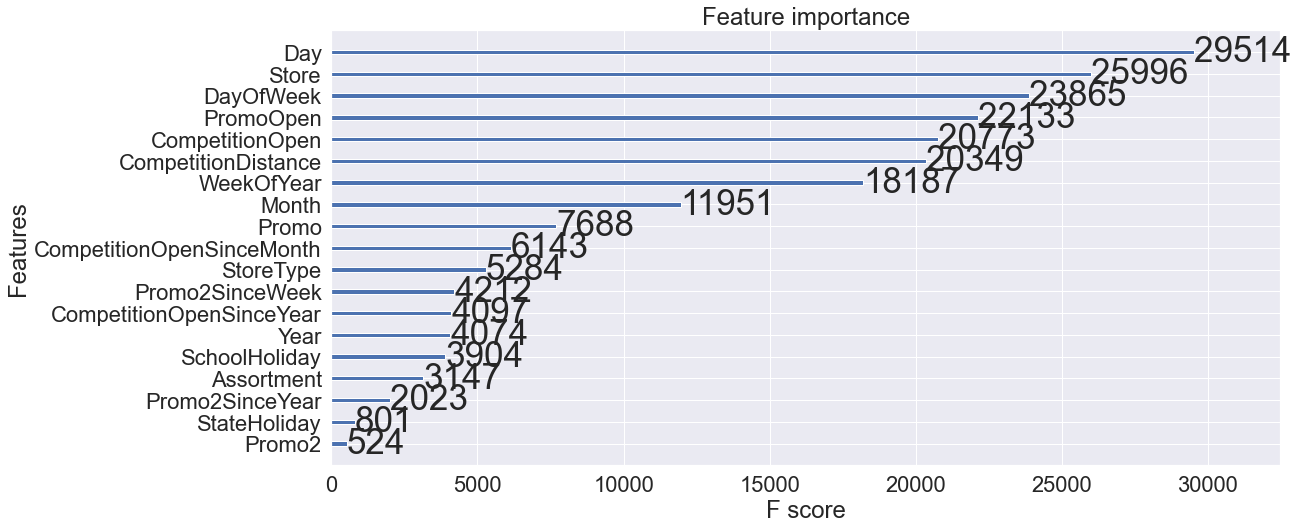

In [63]:
from xgboost import plot_importance
plot_importance(xgb_model);

**Prediction to unseen data**

In [64]:
# predictions to unseen data
unseen = xgb.DMatrix(test_store[predictors])
test_p = xgb_model.predict(unseen)

forecasts = pd.DataFrame({'Id': test['Id'], 
                          'Sales': np.exp(test_p)})
# forecasts
forecasts.head()

,Id,Sales
Date,,
2015-09-17,1,4428.599609
2015-09-17,2,4490.351074
2015-09-17,3,4628.084961
2015-09-17,4,5121.704590
2015-09-17,5,6562.314941


# References
<hr style="border:2px solid black"> </hr>


- https://github.com/datageekette/rossmann_TSA_forecasts
- https://www.kaggle.com/c/rossmann-store-sales

